# AdventureWorks Försäljningsanalys

---


Beskriv kort vad analysen/projektet handlar om

## Setup

### Engine för att ansluta till SQL Servern

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

import os
from dotenv import load_dotenv

load_dotenv()

user = os.getenv("user")
password = quote_plus(os.getenv("password"))
server = os.getenv("server")
database = os.getenv("database")
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\josef\AppData\Local\Temp\ipykernel_17708\114066081.py:27: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


### Hjälp-funktion för att läsa SQL-kod (?)

In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

Förklara meningen med den här hjälpfunktionen. Hur hade det blivit om jag inte skapade den här funktionen först? Vad gör den liksom/vad förenklar den?

## Visualiseringar

### Visualisering 1: Antal produkter per kategori

Hur många produkter finns i varje kategori?

Tabeller som används:

- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

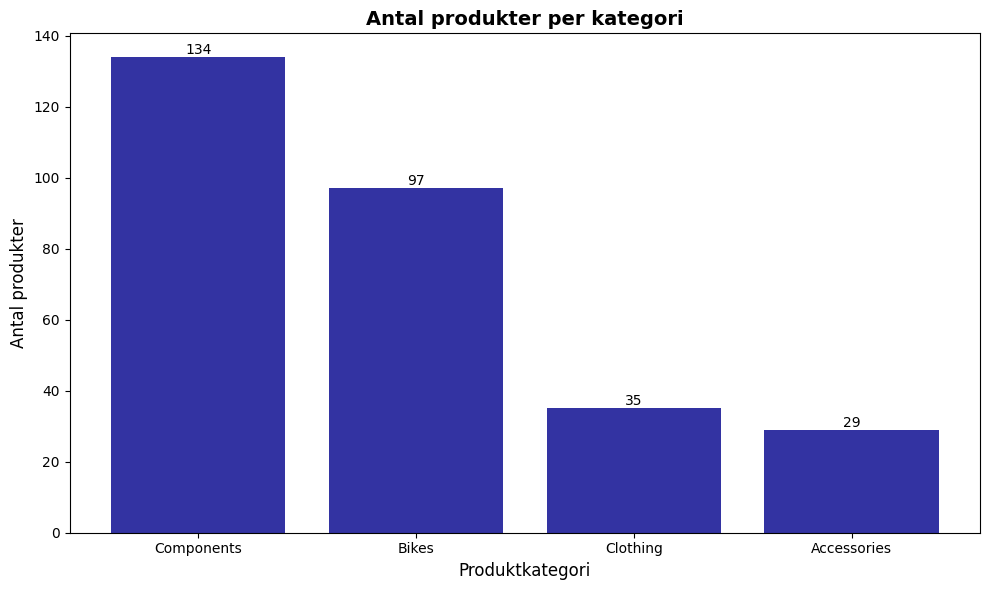

In [6]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(df_vis1["CategoryName"], df_vis1["ProductCount"], color="darkblue", alpha=0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom"
    )

ax.set_xlabel("Produktkategori", fontsize=12)
ax.set_ylabel("Antal produkter", fontsize=12)
ax.set_title("Antal produkter per kategori", fontsize=14, fontweight="bold")

plt.tight_layout()


##### Metod

- JOINA tabellerna 
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultatet

#### Insikter - Antal produkter per kategori

- Components är största kategorin med 134 produkter
- Accessories är minsta kategorin med 29 produkter 

Detta indikerar på att företaget är starkt fokuserat på komponenter och reservdelar. 

Komponenter utgör nästan mer än hälften av sortimentet. 

Accessoarer kan vara ett område där företaget kan utvecklas. 

---

### Visualisering 2: Försäljning per produktkategori

Vad är den totala försäljningen för varje produktkategori? 

Tabeller som används: 

- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail 

Total försäljning: 109 846 381.40 USD


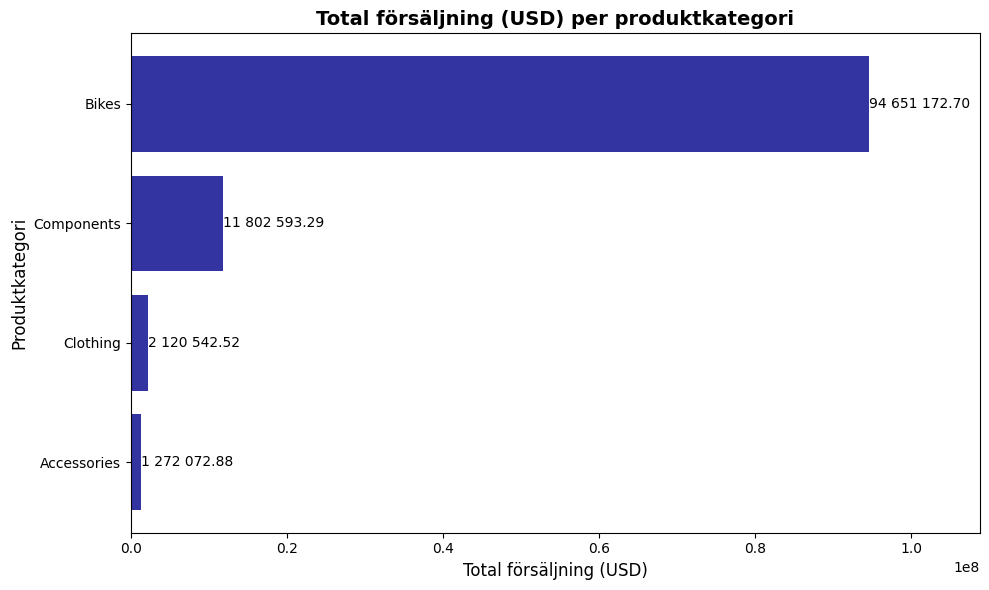

In [10]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail AS sod
INNER JOIN Production.Product AS p ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory AS psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory AS pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalRevenue ASC
"""

df_vis2 = query_df(query_vis2)

_, ax = plt.subplots(figsize=(10,6))

bars = ax.barh(df_vis2["CategoryName"], df_vis2["TotalRevenue"], color="darkblue", alpha=0.8)

for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.2f}".replace(",", " "),
        va="center",
        ha="left"
    )

ax.set_xlabel("Total försäljning (USD)", fontsize=12)
ax.set_ylabel("Produktkategori", fontsize=12)
ax.set_title("Total försäljning (USD) per produktkategori", fontsize=14, fontweight="bold")
ax.set_xlim(0, df_vis2["TotalRevenue"].max() * 1.15)

plt.tight_layout()

query_vis2_2 = """
SELECT
    SUM(sod.LineTotal) AS TotalRevenue
FROM Sales.SalesOrderDetail AS sod
"""

df_vis2_2 = query_df(query_vis2_2)

total_revenue = df_vis2_2.iloc[0,0]

print(f"Total försäljning: {total_revenue:,.2f}".replace(",", " ") + " USD") 

##### Metod:

- JOIN:a tabellerna (INNER JOIN)
- Summera SalesOrderDetail.LineTotal per produktkategori 
- Skapa horisontellt stapeldiagram 
- Analysera resultatet

f"{int(width):;} = format-specificerar i Python som säger "skriv talet med tusentalsavskiljare"

width är bredden på stapeln, alltså försälningen 

SUM() från SQL blir ofta float

*

Rabatt och inte rabatt, skillnaden 

*

Blir det någon skillnad mellan INNER JOIN och LEFT JOIN i den här query:n?

#### Insikter - Försäljning per produktkategori

- Kategorin med störst försäljning är Bikes där total försäljning är 94 651 172,70 USD
- Kategorin med minst försäljning är Accessories där total försäljning är 1 272 072,88 USD 
- Intäkterna för Bikes utgör mer än 85 % av total försäljning och är den helt dominerande produktkategorin 
- Förändringar i produktkategorin Bikes har stor påverkan på den totala försäljningen

---


### Visualisering 3: Försäljningstrend över tid

Hur har försäljningen utvecklats över tid? 

Tabeller som används:

* Sales.SalesOrderHeader

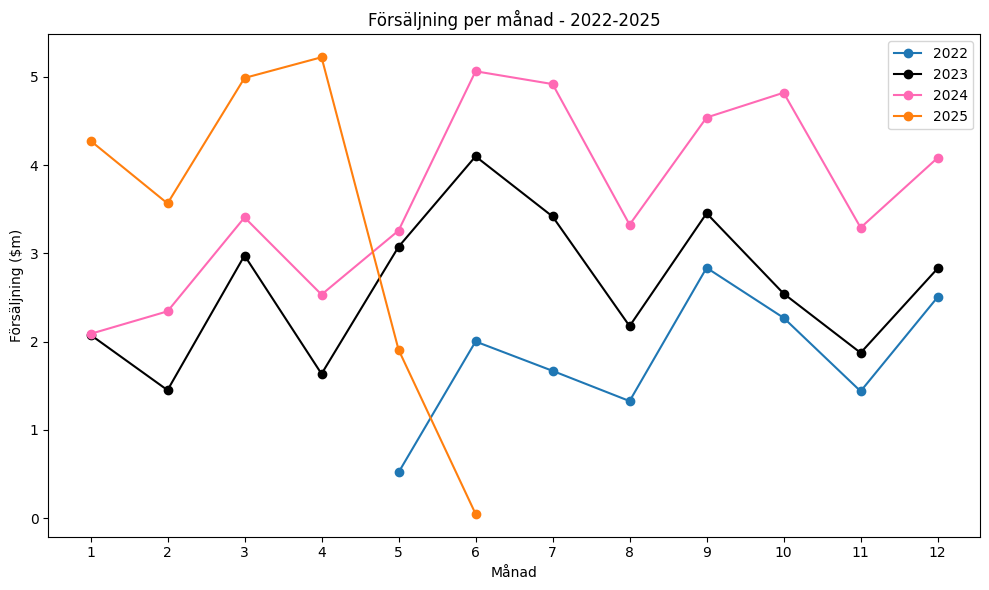

In [28]:
query_vis3_2022 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2022-01-01'
    AND soh.OrderDate < '2023-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2023 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2023-01-01'
    AND soh.OrderDate < '2024-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2024 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2024-01-01'
    AND soh.OrderDate < '2025-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

query_vis3_2025 = """
SELECT
    MONTH(soh.OrderDate) AS OrderMonth,
    SUM(soh.SubTotal) AS TotalRevenue    
FROM Sales.SalesOrderHeader AS soh
WHERE soh.OrderDate >= '2025-01-01'
    AND soh.OrderDate < '2026-01-01'
GROUP BY 
    MONTH(soh.OrderDate)
ORDER BY 
    OrderMonth
"""

df_vis3_2022 = query_df(query_vis3_2022)
df_vis3_2023 = query_df(query_vis3_2023)
df_vis3_2024 = query_df(query_vis3_2024)
df_vis3_2025 = query_df(query_vis3_2025)

plt.figure(figsize=(10,6))

plt.plot(df_vis3_2022["OrderMonth"], df_vis3_2022["TotalRevenue"] / 1_000_000, marker="o", label="2022")
plt.plot(df_vis3_2023["OrderMonth"], df_vis3_2023["TotalRevenue"] / 1_000_000, marker="o", label="2023", color="black")
plt.plot(df_vis3_2024["OrderMonth"], df_vis3_2024["TotalRevenue"] / 1_000_000, marker="o", label="2024", color="hotpink")
plt.plot(df_vis3_2025["OrderMonth"], df_vis3_2025["TotalRevenue"] / 1_000_000, marker="o", label="2025")

plt.xlabel("Månad")
plt.ylabel("Försäljning ($m)")
plt.title("Försäljning per månad - 2022-2025")
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()



##### Metod

#### Insikter - Försäljningstrend över tid

- Försäljningen har ökat varje år 
- Försäljningsmönstret ser liknande ut under åren 2022-2024 med en försäljningstopp i juni
    - Med verksamhet på norra halvklotet är det rimligt att försäljning av cyklar ökar under tidig sommar och hösten då vädret är lämpligast för cykelturer
- Månader med lägst försäljning skiljer sig lite från år till år, men 2023 var februari den månad med lägst försäljning och 2024 var det januari
    - Överlag är försäljningen lägre under vintermånaderna, för att öka något runt årskiften (kanske på grund av nyårslöften?)
- 2025 skiljer sig åt från tidigare år
    - total försäljning ökade markant i början av året jämfört med 2024
    - mellan mars och april ökade försäljningen, vilket inte har hänt under tidigare år
    - försäljningen slår rekord i april 2025 för att sedan dyka rejält och gå emot tidigare trender 
- Den månad med absolut lägst försäljning är juni 2025 

AdventureWorks rekommenderas att vidare undersöka varför försäljningen störtdök efter april 2025. Är datan komplett? Var det utförsäljning under våren 2025 för att ge plats åt nytt sortiment? Vad har hänt?